In [2]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

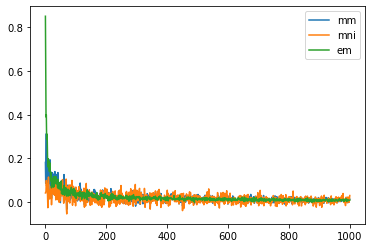

In [3]:
#this cell defines functions that compute MM and MNI in a geometrically clear scaling

def compute_mm(mu, Z, lambdas):
    Q = Z * np.sqrt(lambdas)
    n, d = Q.shape
    p = cp.Variable(n)
    objective = cp.Minimize(cp.sum_squares(mu + Q.T @ p))
    constraints = [p >= 0, cp.sum(p) == 1]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return mu + Q.T @ p.value

def compute_mni(mu, Z, lambdas):
    Q = Z * np.sqrt(lambdas)
    n, d = Q.shape
    p = cp.Variable(n)
    objective = cp.Minimize(cp.sum_squares(mu + Q.T @ p))
    constraints = [cp.sum(p) == 1]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return mu + Q.T @ p.value

def compute_em(mu, Z, lambdas):
    Q = Z * np.sqrt(lambdas)
    n, d = Q.shape
    return mu + np.mean(Q, axis = 0)

def compute_mu_perp(mu, Z, lambdas):
    Q = Z * np.sqrt(lambdas)
    return mu - np.linalg.pinv(Q) @ (Q @ mu) 

def compute_mm_proxy(mu, Z, lambdas):
    #this is like mm, but we don't restrict dual variables to sum to one
    Q = Z * np.sqrt(lambdas)
    n, d = Q.shape
    p = cp.Variable(n)
    objective = cp.Minimize(cp.sum_squares(mu + Q.T @ p))
    constraints = [p >= 0]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return mu + Q.T @ p.value

estimators = {
    'mm': compute_mm,
    'mni': compute_mni,
    'em': compute_em
}

n = 100
p = 1000
lambdas = 1/np.arange(1, p+1)
Z = np.random.randn(n, p)
mu = lambdas**0.7
mm = compute_mm(mu, Z, lambdas)
mni = compute_mni(mu, Z, lambdas)
em = compute_em(mu, Z, lambdas)
plt.plot(mm, label='mm')
plt.plot(mni, label='mni')
plt.plot(em, label='em')
plt.legend()

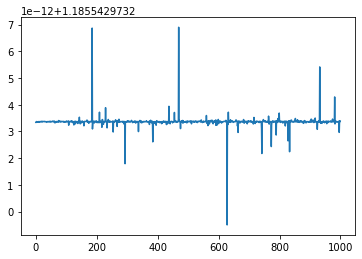

In [3]:
#check that mni is indeed another scaling of the same estimator
mni_other_scaling = np.linalg.pinv(Z*np.sqrt(lambdas) + mu) @ np.ones(n)
plt.plot(mni_other_scaling/mni)

In [19]:
#there are many hyperparameters in the problem: how lambdas decay, how large is mu and how well it is aligned with lambdas
#there are also several target quantities we might want to look at: scalar product with mu, Euclidean norm or norm in Sigma

#here we implement target quantities:
def scal_prod(w, mu, lambdas):
    return w @ mu

def eucl_norm(w, mu, lambdas):
    return np.linalg.norm(w)

def norm_in_sigma(w, mu, lambdas):
    return np.linalg.norm(w * np.sqrt(lambdas))

def classification_err(w, mu, lambdas):
    return scal_prod(w, mu, lambdas)/norm_in_sigma(w, mu, lambdas)

target_quantities = {
    'scal prod':scal_prod,
    'eucl norm': eucl_norm,
    'norm in sigma': norm_in_sigma,
    'classif err': classification_err
}
target_names = [name for name in target_quantities]

In [45]:
#All experiments are going to have the following form: there is a scalar parameter, and a function that generates a problem
#instance given this parameter. For each value of the parameter we generate an instance and compute all the target quantities

def conduct_experiment(parameter_range, generate_instance):
    res = []
    for parameter in parameter_range:
        mu, Z, lambdas = generate_instance(parameter)
        res += [{}]
        for estimator_name in estimators:
            res[-1][estimator_name] = {}
            w = estimators[estimator_name](mu, Z, lambdas)
            for target_name in target_quantities:
                res[-1][estimator_name][target_name] = target_quantities[target_name](w, mu, lambdas)
    return res

In [40]:
#experimenting with decay of lambdas
n = 100
p = 1000
gamma_range = np.linspace(0, 3, 20)
Z = np.random.randn(n, p)
mu = np.ones(p) #/ np.sqrt(p)
mu[10:] *= 0
result = conduct_experiment(
    gamma_range,
    lambda gamma: (mu, Z, 1/np.arange(1, p+1)**gamma),
    scal_prod
)

classif err


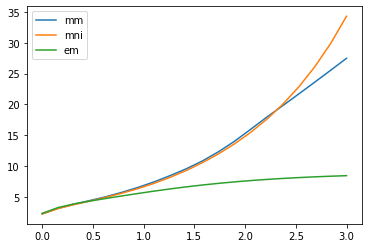

In [41]:
target_name = target_names[3]
print(target_name)
eps = 0
for estimator_name in estimators:
    plt.plot(gamma_range, [eps + res[estimator_name][target_name] for res in result], label=estimator_name)
    eps += 0
plt.legend()

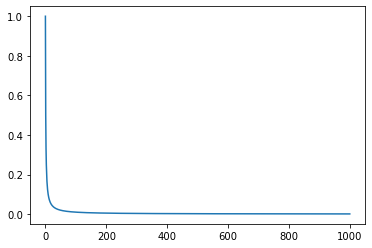

In [44]:
#now let's fix lambdas to be a heavy-tailed sequence as we like it.
n = 100
p = 1000
k = 10
lambdas = 1/np.arange(1, p+1)
# lambdas[:k] *= np.exp(0.0 * (k - np.arange(1, k+1)))
plt.plot(lambdas)

In [78]:
#Our goal for now is to investigate what happens with the scalar product of mm solution with mu
#depending on how well mu is aligned with Sigma
mu = np.zeros(p)
mu[:k] = 1
Z = np.random.randn(n, p)
mu_scale_range = np.logspace(-2, 4, 100)
result = conduct_experiment(
    mu_scale_range,
    lambda mu_scale: (mu * mu_scale, np.random.randn(n,p), lambdas)
)

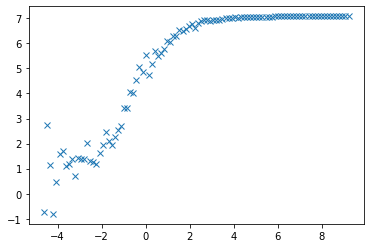

In [89]:
Q = Z * np.sqrt(lambdas)
mu_perp = mu - np.linalg.pinv(Q) @ Q @ mu
mu_perp_sq_norm = np.linalg.norm(mu_perp)**2
res_to_plot = []
i = 0
for mu_scale in mu_scale_range:
    res_to_plot += [result[i]['mm']['scal prod'] /mu_scale**2 /mu_perp_sq_norm]
    i += 1
plt.plot(np.log(mu_scale_range), res_to_plot, 'x', label='mm')

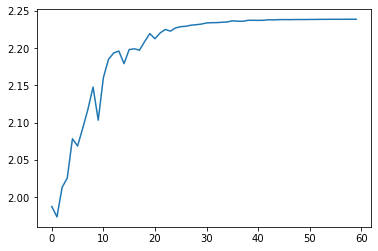

In [88]:
plt.plot(res_to_plot[40:])

# Trying very orthogonal tails below

In [54]:
k = 5
n = 80
p = 2000
Z = np.random.randn(n, p)
lambdas = np.ones(p)
lambdas[:k] *= 1000
mu = np.zeros(p)
mu[:k] = 100 * np.random.rand(k)
mm = compute_mm(mu, Z, lambdas)
mni = compute_mni(mu, Z, lambdas)
mm_proxy = compute_mm_proxy(mu, Z, lambdas)
mni_proxy = compute_mu_perp(mu, Z, lambdas)

[2.72863217 3.0835333  3.80789611 2.2949184  2.65481497]


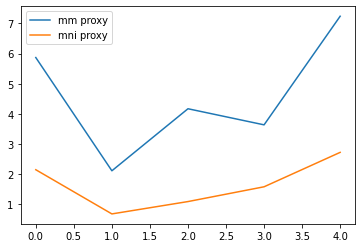

In [55]:
plt.plot(mm_proxy[:k], label='mm proxy')
plt.plot(mni_proxy[:k], label='mni proxy')

plt.legend()
print(mm_proxy[:k]/mni_proxy[:k] )

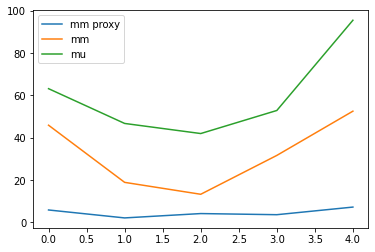

In [58]:
plt.plot(mm_proxy[:k], label='mm proxy')
plt.plot(mm[:k], label='mm')
# plt.plot(mu[:k], label='mu')
plt.legend()

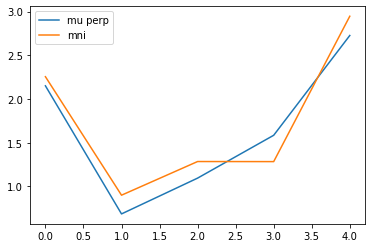

In [57]:
plt.plot(mni_proxy[:k], label='mu perp')
plt.plot(mni[:k], label='mni')
plt.legend()

# Trying exactly orthogonal tails below.

In [8]:
k = 5
n = 80
p = 2000
Z = np.hstack((np.random.randn(n, k), np.eye(n)))
lambdas = np.hstack((np.ones(k) * 100, np.ones(n)))
mu = np.hstack((np.random.rand(k) * 10, np.zeros(n)))

In [9]:
mm = compute_mm(mu, Z, lambdas)

In [10]:
Z.shape

(80, 85)

In [13]:
Q = Z * np.sqrt(lambdas)

def compute_reduced_duals(Z, lambdas, k, v):
    n, p = Z.shape
    Q = Z * np.sqrt(lambdas)
    A_k = Q[:, k:] @ Q[:, k:].T
    A_k_inv = np.linalg.inv(A_k)
    boldeta = cp.Variable(k)
    bzeta = cp.Variable(n, nonneg=True)
    xi = cp.Variable()
    cost = cp.quad_form(bzeta + xi * np.ones(n) - Q[:, :k] @ boldeta, A_k_inv) - xi + boldeta.T @ v
    problem = cp.Problem(cp.Minimize(cost), [])
    problem.solve()
    return boldeta.value, bzeta.value, xi.value
boldeta, bzeta, xi = compute_reduced_duals(Z, lambdas, k, np.ones(k))    

0.006426848704305729


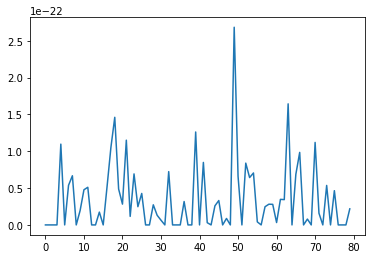

In [15]:
print(xi)
plt.plot(bzeta)